In [343]:
import os 
import pandas as pd
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.engine.url import URL
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import sys
import boto3
import utils_schema
from utils_schema import get_otu_and_taxo
from scipy.stats import pearsonr
from scipy.stats import gmean
import statsmodels.api as sm


In [3]:
utils_schema


<module 'utils_schema' from '/Users/sebastianbedoyamazo/Google Drive/Mi unidad/siwa/iluma-kb/utils_schema.py'>

In [4]:
load_dotenv("/Users/sebastianbedoyamazo/Documents/Data-exploration-and-others/.env", override=True)

True

In [5]:
os.environ
import utils_schema
sys.path.append("/Users/sebastianbedoyamazo/Documents/Data-exploration-and-others")
import utils_dataexp as u


Reading aws keys from .env successfully!!


In [6]:
s3_client = boto3.client("s3")
s3_resource = boto3.resource("s3")


In [7]:
url = URL.create(
    drivername='redshift+redshift_connector',
    host='iluma-kb-1.cn4ff1ztoyt9.us-east-1.redshift.amazonaws.com',
    port=5439,
    database='dev',
    username='awsuser',
    password='Ilumasiwa1'
)

engine = create_engine(url)
Session = sessionmaker()
Session.configure(bind=engine)
session = Session()

redshift_metadata = sa.MetaData(bind=session.bind)



# Check functions  

In [8]:
def common_features(a, b):
    a = [element.lower() for element in a]
    b = [element.lower() for element in b]
    result = [i for i in a if i in b]
    return result


# Feature and taxonomy from broiler experiments (267, 271, 321, 325, 326, 335, 345, 347

## Run where are those experiments


### 20181130 (E267, E291), 
### 20210527 (E321, E325), 
### 20211206 (E326, E335), 
### 20211214 (E345)
### 20220930 (E347)


In [ ]:
s3_client.list_objects_v2(Bucket="siwamicrobiome", Prefix="exports/")["Contents"]


In [ ]:
s3_client.list_objects_v2(Bucket="siwamicrobiome", Prefix="exports/20210527")["Contents"]

In [ ]:
s3_client.list_objects_v2(Bucket="siwamicrobiome", Prefix="exports/20181130")["Contents"]

In [ ]:
s3_client.list_objects_v2(Bucket="siwamicrobiome", Prefix="exports/20211206")["Contents"]

In [ ]:
s3_client.list_objects_v2(Bucket="siwamicrobiome", Prefix="exports/20211214")["Contents"]

In [347]:
feat267_271 = u.read_csv_s3("exports/20181130/20181130.feature-table.tsv", "siwamicrobiome", sep="\t")
feat321_325 = u.read_csv_s3("exports/20210527/20210527.feature-table.tsv", "siwamicrobiome", sep="\t")
feat326_335 = u.read_csv_s3("exports/20211206/20211206.feature-table.tsv", "siwamicrobiome", sep="\t")
feat345 = u.read_csv_s3("exports/20211214/20211214.feature-table.tsv", "siwamicrobiome", sep="\t")
feat347 = u.read_csv_s3("exports/20220930/20220930.feature-table.tsv", "siwamicrobiome", sep="\t")

In [393]:
feat = feat267_271.merge(feat321_325, how='left', left_on =['OTU'], right_on =['OTU'])
feat = feat.merge(feat326_335, how='left', left_on =['OTU'], right_on =['OTU'])
feat = feat.merge(feat345, how='left', left_on =['OTU'], right_on =['OTU'])
feat = feat.merge(feat347, how='left', left_on =['OTU'], right_on =['OTU'])
feat.head(1)

,H001_01C-M,H001_01F-M,H001_01I-M,H001_02C-M,H001_02F-M,H001_03F-M,H001_03I-M,H001_04C-M,H001_04F-M,H001_05F-M,...,C120_03C-M,C120_04C-M,C120_05C-M,C120_06C-M,C124_01F-M,C124_02F-M,C124_03F-M,C124_04F-M,C124_05F-M,C124_06F-M
0,0.0,0.0,59.0,0.0,127.0,30.0,301.0,0.0,41.0,19.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,24.0


In [362]:
samples = list(feat[[i for i in feat.columns if "_" in i]].columns)
print(len(samples))
print(len(set(samples)))

2345
2345


In [363]:
samples.append("OTU")

In [21]:
samples267_271 = list(feat267_271[[i for i in feat267_271.columns if "_" in i]].columns)
samples321_325 = list(feat321_325[[i for i in feat321_325.columns if "_" in i]].columns)
samples326_335 = list(feat326_335[[i for i in feat326_335.columns if "_" in i]].columns)
samples345 = list(feat345[[i for i in feat345.columns if "_" in i]].columns)
samples347 = list(feat347[[i for i in feat347.columns if "_" in i]].columns)

samples267_271.append("OTU")
samples321_325.append("OTU")
samples326_335.append("OTU")
samples345.append("OTU")
samples347.append("OTU")


In [349]:
tax267_271 = u.read_csv_s3("exports/20181130/20181130.silva.taxonomy_processed.csv", "siwamicrobiome")
tax321_325 = u.read_csv_s3("exports/20210527/20210527.silva.taxonomy_processed.csv", "siwamicrobiome")
tax326_335 = u.read_csv_s3("exports/20211206/20211206.silva.taxonomy_processed.csv", "siwamicrobiome")
tax345 = u.read_csv_s3("exports/20211214/20211214.taxonomy_processed.csv", "siwamicrobiome")
tax347 = u.read_csv_s3("exports/20220930/20220930.taxonomy_processed.csv", "siwamicrobiome")


In [392]:
taxonomy = pd.merge(tax267_271, tax321_325, on=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species','OTU', 'SciName'], how='left')
taxonomy = pd.merge(taxonomy, tax326_335, on=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species','OTU', 'SciName'], how='left')
taxonomy = pd.merge(taxonomy, tax345, on=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species','OTU', 'SciName'], how='left')
taxonomy = pd.merge(taxonomy, tax347, on=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species','OTU', 'SciName'], how='left')
taxonomy.head(1)

,Kingdom,Phylum,Class,Order,Family,Genus,Species,OTU,SciName
0,Bacteria,Cyanobacteria,Cyanobacteriia,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,0a3cf58d4ca062c13d42c9db4ebcbc53,UNKNOWN UNKNOWN


In [391]:
oturel = u.convert_relative(feat[samples])
oturel.head(1)

OTUS are index


,H001_01C-M,H001_01F-M,H001_01I-M,H001_02C-M,H001_02F-M,H001_03F-M,H001_03I-M,H001_04C-M,H001_04F-M,H001_05F-M,...,C120_03C-M,C120_04C-M,C120_05C-M,C120_06C-M,C124_01F-M,C124_02F-M,C124_03F-M,C124_04F-M,C124_05F-M,C124_06F-M
0a3cf58d4ca062c13d42c9db4ebcbc53,0.0,0.0,0.004866,0.0,0.021384,0.002627,0.036716,0.0,0.003586,0.003195,...,0.0,0.0,0.0,0.0,0.0,0.00131,0.0,0.0,0.0,0.002019


In [456]:
specie_rel = u.aggregate_taxa("Species", taxonomy, oturel)
specie_rel.head(1)


,H001_01C-M,H001_01F-M,H001_01I-M,H001_02C-M,H001_02F-M,H001_03F-M,H001_03I-M,H001_04C-M,H001_04F-M,H001_05F-M,...,C120_03C-M,C120_04C-M,C120_05C-M,C120_06C-M,C124_01F-M,C124_02F-M,C124_03F-M,C124_04F-M,C124_05F-M,C124_06F-M
UNKNOWN,0.88383,0.996654,0.993897,0.92006,0.997643,0.937297,0.995853,0.926667,1.0,1.0,...,0.924946,0.877519,0.920573,0.908263,0.796523,0.988994,0.997087,0.967612,0.959818,0.968374


In [408]:
specie_relt = specie_rel.T
specie_relt['fullsampleid'] = specie_relt.index
specie_relt = specie_relt.reset_index(drop=True)
specie_relt.head(1)

,UNKNOWN,Lactobacillus_aviarius,Butyricicoccus_pullicaecorum,[Clostridium]_spiroforme,Anaerostipes_butyraticus,Anaerotignum_lactatifermentans,Eubacterium_sp.,Enterococcus_cecorum,bacterium_ic1391,Lachnoclostridium_phocaeense,...,Wallemia_sebi,Alistipes_indistinctus,Muribacter_muris,bacterium_NLAE-zl-H528,Prototheca_kruegeri,Alkalibaculum_bacchi,Pseudomonas_xanthomarina,Clonostachys_rosea,Sphingomonas_oligoaromativorans,fullsampleid
0,0.88383,0.0,0.014011,0.037653,0.000973,0.054972,0.001557,0.0,0.0,0.004476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H001_01C-M


# compositional data transform

## Centred Log-Ratio transformation

In [473]:
dfespecie = specie_rel+0.1
dfspecie_clr = np.log(dfespecie / gmean(dfespecie, axis=1)[:, np.newaxis])
dfspecie_clr = dfspecie_clr.T
dfspecie_clr['fullsampleid'] = dfspecie_clr.index
dfspecie_clr = dfspecie_clr.reset_index(drop=True)
dfspecie_clr

,UNKNOWN,Lactobacillus_aviarius,Butyricicoccus_pullicaecorum,[Clostridium]_spiroforme,Anaerostipes_butyraticus,Anaerotignum_lactatifermentans,Eubacterium_sp.,Enterococcus_cecorum,bacterium_ic1391,Lachnoclostridium_phocaeense,...,Wallemia_sebi,Alistipes_indistinctus,Muribacter_muris,bacterium_NLAE-zl-H528,Prototheca_kruegeri,Alkalibaculum_bacchi,Pseudomonas_xanthomarina,Clonostachys_rosea,Sphingomonas_oligoaromativorans,fullsampleid
0,-0.022552,-0.135475,0.093100,0.295185,-0.041324,0.409885,-0.007267,-0.014324,-0.014074,0.023389,...,-7.833198e-07,-8.222102e-07,-0.000002,-7.707896e-07,-9.506005e-07,-8.156055e-07,-8.505821e-07,-7.460450e-07,-0.000001,H001_01C-M
1,0.086014,-0.135475,-0.038020,-0.001328,-0.044941,-0.028188,-0.022714,-0.014324,-0.014074,-0.020395,...,-7.833198e-07,-8.222102e-07,-0.000002,-7.707896e-07,-9.506005e-07,-8.156055e-07,-8.505821e-07,-7.460450e-07,-0.000001,H001_01F-M
2,0.083498,-0.135475,-0.027356,-0.015352,-0.028984,-0.021612,-0.022714,-0.014324,-0.010781,-0.020395,...,-7.833198e-07,-8.222102e-07,-0.000002,-7.707896e-07,-9.506005e-07,-8.156055e-07,-8.505821e-07,-7.460450e-07,-0.000001,H001_01I-M
3,0.013613,-0.135475,0.090218,0.306472,-0.051006,-0.028188,0.020510,-0.014324,-0.004424,0.005133,...,-7.833198e-07,-8.222102e-07,-0.000002,-7.707896e-07,-9.506005e-07,-8.156055e-07,-8.505821e-07,-7.460450e-07,-0.000001,H001_02C-M
4,0.086916,-0.135475,-0.038020,-0.015999,-0.051006,-0.028188,-0.022714,-0.014324,-0.014074,-0.020395,...,-7.833198e-07,-8.222102e-07,-0.000002,-7.707896e-07,-9.506005e-07,-8.156055e-07,-8.505821e-07,-7.460450e-07,-0.000001,H001_02F-M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2340,0.079005,-0.135475,-0.038020,-0.024382,-0.051006,-0.028188,-0.022714,-0.014324,-0.014074,-0.011265,...,-7.833198e-07,-8.222102e-07,-0.000002,-7.707896e-07,-9.506005e-07,-8.156055e-07,-8.505821e-07,-7.460450e-07,-0.000001,C124_02F-M
2341,0.086409,-0.135475,-0.038020,-0.024382,-0.051006,-0.028188,-0.022714,-0.014324,-0.014074,-0.020395,...,-7.833198e-07,-8.222102e-07,-0.000002,-7.707896e-07,-9.506005e-07,-8.156055e-07,-8.505821e-07,-7.460450e-07,-0.000001,C124_03F-M
2342,0.059175,-0.135475,-0.038020,-0.024382,-0.051006,-0.028188,0.033600,-0.014324,0.024664,-0.006449,...,-7.833198e-07,-8.222102e-07,-0.000002,-7.707896e-07,-9.506005e-07,-8.156055e-07,-8.505821e-07,-7.460450e-07,-0.000001,C124_04F-M
2343,0.051848,-0.135475,-0.038020,-0.017898,-0.035613,-0.028188,-0.008307,-0.014324,-0.009082,0.006268,...,-7.833198e-07,-8.222102e-07,-0.000002,-7.707896e-07,-9.506005e-07,-8.156055e-07,-8.505821e-07,-7.460450e-07,-0.000001,C124_05F-M


In [460]:
dfespecie

,H001_01C-M,H001_01F-M,H001_01I-M,H001_02C-M,H001_02F-M,H001_03F-M,H001_03I-M,H001_04C-M,H001_04F-M,H001_05F-M,...,C120_03C-M,C120_04C-M,C120_05C-M,C120_06C-M,C124_01F-M,C124_02F-M,C124_03F-M,C124_04F-M,C124_05F-M,C124_06F-M
UNKNOWN,0.983830,1.096654,1.093897,1.020060,1.097643,1.037297,1.095853,1.026667,1.1,1.1,...,1.024946,0.977519,1.020573,1.008263,0.896523,1.088994,1.097087,1.067612,1.059818,1.068374
Lactobacillus_aviarius,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,0.100000,0.100000,0.100000,0.100000,0.178705,0.100000,0.100000,0.100000,0.100000,0.100000
Butyricicoccus_pullicaecorum,0.114011,0.100000,0.101072,0.113682,0.100000,0.105342,0.102318,0.130760,0.1,0.1,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
[Clostridium]_spiroforme,0.137653,0.102332,0.100907,0.139216,0.100842,0.121018,0.100366,0.102222,0.1,0.1,...,0.100000,0.100000,0.100000,0.100557,0.100000,0.100000,0.100000,0.100000,0.100651,0.100000
Anaerostipes_butyraticus,0.100973,0.100608,0.102227,0.100000,0.100000,0.113661,0.100000,0.100000,0.1,0.1,...,0.101042,0.106596,0.107889,0.117778,0.100000,0.100000,0.100000,0.100000,0.101551,0.101598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Prototheca_kruegeri,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
Alkalibaculum_bacchi,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
Pseudomonas_xanthomarina,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
Clonostachys_rosea,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000


## Log-ratio transformation

In [484]:
pseudocount = specie_rel + 1

row_sums = pseudocount.sum(axis=1)
prop_df = pseudocount.div(row_sums, axis=0)

# Aplicar la transformación log-ratio
dfspecie_lr = np.log(prop_df)
dfspecie_lr


dfspecie_lr = dfspecie_lr.T
dfspecie_lr['fullsampleid'] = dfspecie_lr.index
dfspecie_lr = dfspecie_lr.reset_index(drop=True)
dfspecie_lr

,UNKNOWN,Lactobacillus_aviarius,Butyricicoccus_pullicaecorum,[Clostridium]_spiroforme,Anaerostipes_butyraticus,Anaerotignum_lactatifermentans,Eubacterium_sp.,Enterococcus_cecorum,bacterium_ic1391,Lachnoclostridium_phocaeense,...,Wallemia_sebi,Alistipes_indistinctus,Muribacter_muris,bacterium_NLAE-zl-H528,Prototheca_kruegeri,Alkalibaculum_bacchi,Pseudomonas_xanthomarina,Clonostachys_rosea,Sphingomonas_oligoaromativorans,fullsampleid
0,-7.776716,-7.78597,-7.750749,-7.725790,-7.765369,-7.710146,-7.760870,-7.762033,-7.761532,-7.757714,...,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,H001_01C-M
1,-7.718550,-7.78597,-7.764662,-7.760422,-7.765734,-7.763660,-7.762426,-7.762033,-7.761532,-7.762179,...,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,H001_01F-M
2,-7.719931,-7.78597,-7.763590,-7.761845,-7.764118,-7.763001,-7.762426,-7.762033,-7.761202,-7.762179,...,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,H001_01I-M
3,-7.757666,-7.78597,-7.751072,-7.724286,-7.766342,-7.763660,-7.758018,-7.762033,-7.760563,-7.759597,...,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,H001_02C-M
4,-7.718055,-7.78597,-7.764662,-7.761910,-7.766342,-7.763660,-7.762426,-7.762033,-7.761532,-7.762179,...,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,H001_02F-M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2340,-7.722394,-7.78597,-7.764662,-7.762752,-7.766342,-7.763660,-7.762426,-7.762033,-7.761532,-7.761263,...,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,C124_02F-M
2341,-7.718333,-7.78597,-7.764662,-7.762752,-7.766342,-7.763660,-7.762426,-7.762033,-7.761532,-7.762179,...,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,C124_03F-M
2342,-7.733202,-7.78597,-7.764662,-7.762752,-7.766342,-7.763660,-7.756649,-7.762033,-7.757590,-7.760776,...,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,C124_04F-M
2343,-7.737171,-7.78597,-7.764662,-7.762102,-7.764792,-7.763660,-7.760975,-7.762033,-7.761032,-7.759481,...,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,C124_05F-M


# Query metadata (microbiome, kit, animal) from redshift

In [28]:
query = "SELECT * FROM microbiome as M LEFT JOIN kit as K on M.kitid = K.kitid LEFT JOIN animal as A on M.animalid = A.animalid;"
dfmt = pd.read_sql(query, engine)
print(dfmt.shape)
print(dfmt.columns)
dfmt.head(3)

(3799, 19)
Index(['sampleid', 'fullsampleid', 'kitid', 'runid', 'animalid',
       'samplelocation', 'alphashannon', 'alphaobserved', 'kitid', 'projectid',
       'age', 'treatment', 'treatmentnumber', 'client', 'animalid',
       'animaltype', 'animalnumber', 'house', 'pen'],
      dtype='object')


,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,age,treatment,treatmentnumber,client,animalid,animaltype,animalnumber,house,pen
0,H001_01C,H001_01C-M,H001,20181130,H001_01,cecum,5.775365,114.0,H001,E267,14,Negative control,1,Iluma,H001_01,Broiler,01,1.0,4.0
1,H001_02C,H001_02C-M,H001,20181130,H001_02,cecum,5.967654,148.0,H001,E267,14,Negative control,1,Iluma,H001_02,Broiler,02,2.0,16.0
2,H001_02F,H001_02F-M,H001,20181130,H001_02,feces,2.558017,26.0,H001,E267,14,Negative control,1,Iluma,H001_02,Broiler,02,2.0,16.0


In [396]:
dfmk = dfmt.loc[dfmt['projectid'].isin(['E267', 'E271', 'E345', 'E347'])]
print(dfmk.columns)
print(dfmk.shape)
dfmk.head()




Index(['sampleid', 'fullsampleid', 'kitid', 'runid', 'animalid',
       'samplelocation', 'alphashannon', 'alphaobserved', 'kitid', 'projectid',
       'age', 'treatment', 'treatmentnumber', 'client', 'animalid',
       'animaltype', 'animalnumber', 'house', 'pen'],
      dtype='object')
(1038, 19)


,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,age,treatment,treatmentnumber,client,animalid,animaltype,animalnumber,house,pen
0,H001_01C,H001_01C-M,H001,20181130,H001_01,cecum,5.775365,114.0,H001,E267,14,Negative control,1,Iluma,H001_01,Broiler,01,1.0,4.0
1,H001_02C,H001_02C-M,H001,20181130,H001_02,cecum,5.967654,148.0,H001,E267,14,Negative control,1,Iluma,H001_02,Broiler,02,2.0,16.0
2,H001_02F,H001_02F-M,H001,20181130,H001_02,feces,2.558017,26.0,H001,E267,14,Negative control,1,Iluma,H001_02,Broiler,02,2.0,16.0
3,H001_03F,H001_03F-M,H001,20181130,H001_03,feces,4.429706,106.0,H001,E267,14,Negative control,1,Iluma,H001_03,Broiler,03,3.0,38.0
4,H001_03I,H001_03I-M,H001,20181130,H001_03,ileum,3.153810,43.0,H001,E267,14,Negative control,1,Iluma,H001_03,Broiler,03,3.0,38.0


In [397]:
dfmk['pen'] = dfmk['pen'].astype(float).astype(int)
dfmk['house'] = dfmk['house'].astype(float).astype(int)

/var/folders/8_/97xnhkcj3qvf45tl2cgtc7vc0000gp/T/ipykernel_10246/1587901491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmk['pen'] = dfmk['pen'].astype(float).astype(int)
/var/folders/8_/97xnhkcj3qvf45tl2cgtc7vc0000gp/T/ipykernel_10246/1587901491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmk['house'] = dfmk['house'].astype(float).astype(int)


# Performance dataframe

In [30]:
df_pilot = pd.read_excel("/Users/sebastianbedoyamazo/Documents/siwa_git/Performance/df_pilot.xlsx")
df_pilot.head(1)

,projectid,House,Block,Pen,Trt,BW42,FCR0-42,FCR36-42,BWG0-42,BWG36-42
0,E267,1,Puerta-1A,1,5.0,2857.307692,1.652339,1.618182,2811.993407,719.230769


In [398]:
common_features(df_pilot.columns,dfmk.columns)


['projectid', 'house', 'pen']

In [399]:
df_pilot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   projectid  600 non-null    object 
 1   house      600 non-null    int64  
 2   Block      600 non-null    object 
 3   pen        600 non-null    int64  
 4   Trt        584 non-null    float64
 5   BW42       598 non-null    float64
 6   FCR0-42    384 non-null    float64
 7   FCR36-42   546 non-null    float64
 8   BWG0-42    426 non-null    float64
 9   BWG36-42   600 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 47.0+ KB


In [402]:
dfmk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 3381
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sampleid         1038 non-null   object 
 1   fullsampleid     1038 non-null   object 
 2   kitid            1038 non-null   object 
 3   runid            1038 non-null   object 
 4   animalid         1038 non-null   object 
 5   samplelocation   1038 non-null   object 
 6   alphashannon     1038 non-null   float64
 7   alphaobserved    1038 non-null   float64
 8   kitid            1038 non-null   object 
 9   projectid        1038 non-null   object 
 10  age              1038 non-null   object 
 11  treatment        1038 non-null   object 
 12  treatmentnumber  1038 non-null   int64  
 13  client           1038 non-null   object 
 14  animalid         1038 non-null   object 
 15  animaltype       1038 non-null   object 
 16  animalnumber     1038 non-null   object 
 17  house         

In [404]:
df_pilot['House'].value_counts()

1    160
2    160
3    160
4    120
Name: house, dtype: int64

In [401]:
df_pilot.rename(columns = {'House':'house', 'Pen':'pen'}, inplace = True)
df_pilot['house'] = df_pilot['house'].replace('[^0-9\.]', '', regex=True)
df_pilot['house'] = df_pilot['house'].astype(float).astype(int)
df_pilot['pen'] = df_pilot['pen'].astype(float).astype(int)



# Merge metadata (microbiome, kit, animal) with perfomance data


In [405]:
df = dfmk.merge(df_pilot, how='left', left_on =['projectid', 'house', 'pen'], right_on =['projectid', 'house', 'pen'])
print(df.shape)
print(df.columns)
df.head(1)





(1038, 26)
Index(['sampleid', 'fullsampleid', 'kitid', 'runid', 'animalid',
       'samplelocation', 'alphashannon', 'alphaobserved', 'kitid', 'projectid',
       'age', 'treatment', 'treatmentnumber', 'client', 'animalid',
       'animaltype', 'animalnumber', 'house', 'pen', 'Block', 'Trt', 'BW42',
       'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'],
      dtype='object')


,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,...,animalnumber,house,pen,Block,Trt,BW42,FCR0-42,FCR36-42,BWG0-42,BWG36-42
0,H001_01C,H001_01C-M,H001,20181130,H001_01,cecum,5.775365,114.0,H001,E267,...,01,1,4,Puerta-1A,1.0,2985.0,1.58598,1.632883,2940.515152,740.0


# Merge metadata + performance with otu table (species relative abundance)

## Merge: 
### species relative abundance without transformation
### species relative abundance with CLR transformation
### species relative abundance with LR transformation


In [447]:
df_relation = df.merge(specie_relt, how='left', left_on =['fullsampleid'], right_on =['fullsampleid'])
print(df_relation.shape)
print(df_relation.columns)
df_relation.head(1)


(1038, 159)
Index(['sampleid', 'fullsampleid', 'kitid', 'runid', 'animalid',
       'samplelocation', 'alphashannon', 'alphaobserved', 'kitid', 'projectid',
       ...
       'bacterium_Ellin6519', 'Wallemia_sebi', 'Alistipes_indistinctus',
       'Muribacter_muris', 'bacterium_NLAE-zl-H528', 'Prototheca_kruegeri',
       'Alkalibaculum_bacchi', 'Pseudomonas_xanthomarina',
       'Clonostachys_rosea', 'Sphingomonas_oligoaromativorans'],
      dtype='object', length=159)


,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,...,bacterium_Ellin6519,Wallemia_sebi,Alistipes_indistinctus,Muribacter_muris,bacterium_NLAE-zl-H528,Prototheca_kruegeri,Alkalibaculum_bacchi,Pseudomonas_xanthomarina,Clonostachys_rosea,Sphingomonas_oligoaromativorans
0,H001_01C,H001_01C-M,H001,20181130,H001_01,cecum,5.775365,114.0,H001,E267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [448]:
df_relation_clr = df.merge(dfspecie_clr, how='left', left_on =['fullsampleid'], right_on =['fullsampleid'])
print(df_relation_clr.shape)
print(df_relation_clr.columns)
df_relation_clr.head(1)

(1038, 159)
Index(['sampleid', 'fullsampleid', 'kitid', 'runid', 'animalid',
       'samplelocation', 'alphashannon', 'alphaobserved', 'kitid', 'projectid',
       ...
       'bacterium_Ellin6519', 'Wallemia_sebi', 'Alistipes_indistinctus',
       'Muribacter_muris', 'bacterium_NLAE-zl-H528', 'Prototheca_kruegeri',
       'Alkalibaculum_bacchi', 'Pseudomonas_xanthomarina',
       'Clonostachys_rosea', 'Sphingomonas_oligoaromativorans'],
      dtype='object', length=159)


,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,...,bacterium_Ellin6519,Wallemia_sebi,Alistipes_indistinctus,Muribacter_muris,bacterium_NLAE-zl-H528,Prototheca_kruegeri,Alkalibaculum_bacchi,Pseudomonas_xanthomarina,Clonostachys_rosea,Sphingomonas_oligoaromativorans
0,H001_01C,H001_01C-M,H001,20181130,H001_01,cecum,5.775365,114.0,H001,E267,...,-6.864214e-07,-7.833198e-07,-8.222102e-07,-0.000002,-7.707896e-07,-9.506005e-07,-8.156055e-07,-8.505821e-07,-7.460450e-07,-0.000001


In [485]:
df_relation_lr = df.merge(dfspecie_lr, how='left', left_on =['fullsampleid'], right_on =['fullsampleid'])
print(df_relation_lr.shape)
print(df_relation_lr.columns)
df_relation_lr.head(1)

(1038, 159)
Index(['sampleid', 'fullsampleid', 'kitid', 'runid', 'animalid',
       'samplelocation', 'alphashannon', 'alphaobserved', 'kitid', 'projectid',
       ...
       'bacterium_Ellin6519', 'Wallemia_sebi', 'Alistipes_indistinctus',
       'Muribacter_muris', 'bacterium_NLAE-zl-H528', 'Prototheca_kruegeri',
       'Alkalibaculum_bacchi', 'Pseudomonas_xanthomarina',
       'Clonostachys_rosea', 'Sphingomonas_oligoaromativorans'],
      dtype='object', length=159)


,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,...,bacterium_Ellin6519,Wallemia_sebi,Alistipes_indistinctus,Muribacter_muris,bacterium_NLAE-zl-H528,Prototheca_kruegeri,Alkalibaculum_bacchi,Pseudomonas_xanthomarina,Clonostachys_rosea,Sphingomonas_oligoaromativorans
0,H001_01C,H001_01C-M,H001,20181130,H001_01,cecum,5.775365,114.0,H001,E267,...,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041,-7.760041


# Correlation and graphs analysis

In [493]:
df_relation.groupby('projectid').count()

,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,age,...,bacterium_Ellin6519,Wallemia_sebi,Alistipes_indistinctus,Muribacter_muris,bacterium_NLAE-zl-H528,Prototheca_kruegeri,Alkalibaculum_bacchi,Pseudomonas_xanthomarina,Clonostachys_rosea,Sphingomonas_oligoaromativorans
projectid,,,,,,,,,,,,,,,,,,,,,
E267,341,341,341,341,341,341,341,341,341,341,...,341,341,341,341,341,341,341,341,341,341
E271,338,338,338,338,338,338,338,338,338,338,...,338,338,338,338,338,338,338,338,338,338
E345,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
E347,179,179,179,179,179,179,179,179,179,179,...,179,179,179,179,179,179,179,179,179,179


In [507]:
corr_267 = df_relation.loc[df_relation['projectid'] == 'E267'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_271 = df_relation.loc[df_relation['projectid'] == 'E271'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_345 = df_relation.loc[df_relation['projectid'] == 'E345'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_347 = df_relation.loc[df_relation['projectid'] == 'E347'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)

corr_267_f = corr_267[(corr_267 >= -0.1) | (corr_267 <= 0.1)].dropna()
corr_271_f = corr_271[(corr_271 >= -0.1) | (corr_271 <= 0.1)].dropna()
corr_345_f = corr_345[(corr_345 >= -0.1) | (corr_345 <= 0.1)].dropna()
corr_347_f = corr_347[(corr_347 >= -0.1) | (corr_347 <= 0.1)].dropna()




In [506]:
corr_267 = df_relation.loc[df_relation['projectid'] == 'E267'].groupby('samplelocation').corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']]
corr_267

BW42   FCR0-42  FCR36-42  \
samplelocation                                                                 
cecum          alphashannon                     0.068336 -0.022255  0.069003   
               alphaobserved                    0.107133 -0.063658  0.000890   
               treatmentnumber                 -0.109982 -0.132568 -0.192311   
               house                           -0.456466  0.059859  0.623218   
               pen                              0.098869  0.068018  0.221856   
...                                                  ...       ...       ...   
ileum          Prototheca_kruegeri                   NaN       NaN       NaN   
               Alkalibaculum_bacchi                  NaN       NaN       NaN   
               Pseudomonas_xanthomarina              NaN       NaN       NaN   
               Clonostachys_rosea                    NaN       NaN       NaN   
               Sphingomonas_oligoaromativorans       NaN       NaN       NaN   

                                                 BWG0-42  BWG36-42  
samplelocation                                                      
cecum          alphashannon                     0.070043 -0.029736  
               alphaobserved                    0.109111 -0.019457  
               treatmentnumber                 -0.109521  0.041116  
               house                           -0.454872 -0.750632  
               pen                              0.101308 -0.060629  
...                                                  ...       ...  
ileum          Prototheca_kruegeri                   NaN       NaN  
               Alkalibaculum_bacchi                  NaN       NaN  
               Pseudomonas_xanthomarina              NaN       NaN  
               Clonostachys_rosea                    NaN       NaN  
               Sphingomonas_oligoaromativorans       NaN       NaN  

[432 rows x 5 columns]

# no transformation data

In [488]:
corr_cecum = df_relation.loc[df_relation['samplelocation'] == 'cecum'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_ileum = df_relation.loc[df_relation['samplelocation'] == 'ileum'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_feces = df_relation.loc[df_relation['samplelocation'] == 'feces'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)

corr_cecum = corr_cecum.add_prefix('cecum_')
corr_ileum = corr_ileum.add_prefix('ileum_')
corr_feces = corr_feces.add_prefix('feces_')

df_corr = pd.merge(corr_cecum, corr_ileum, left_index=True, right_index=True, how='left')
df_corr = pd.merge(df_corr, corr_feces, left_index=True, right_index=True, how='left')
df_corr


df_corr.sort_values(by = 'ileum_BW42', ascending = False)



df_corr_f = df_corr[(df_corr >= -0.1) | (df_corr <= 0.1)].dropna()
df_corr_f.head()

,cecum_BW42,cecum_FCR0-42,cecum_FCR36-42,cecum_BWG0-42,cecum_BWG36-42,ileum_BW42,ileum_FCR0-42,ileum_FCR36-42,ileum_BWG0-42,ileum_BWG36-42,feces_BW42,feces_FCR0-42,feces_FCR36-42,feces_BWG0-42,feces_BWG36-42
alphaobserved,0.299666,0.028137,-0.033622,-0.051113,0.089245,-0.125354,-0.002890,-0.122975,0.036803,0.078811,0.087414,-0.009153,-0.154550,0.049770,0.137962
alphashannon,0.297090,-0.083008,-0.212579,0.152162,0.182733,0.055982,0.104557,-0.055759,-0.046672,0.134395,0.138756,0.030286,-0.135466,0.018696,0.138056
[Clostridium]_spiroforme,0.265987,0.051678,-0.164025,0.103258,0.202349,0.075727,-0.043577,-0.099440,0.029816,0.076856,0.148389,-0.106225,-0.068645,0.079835,-0.009307
Butyricicoccus_pullicaecorum,0.231912,-0.108005,-0.100111,0.169471,0.120656,0.047242,-0.042915,-0.091212,0.002227,0.067207,0.165036,-0.102657,-0.097804,0.120066,0.085196
Clostridiales_bacterium,0.222115,-0.141788,-0.157882,0.130917,0.044835,0.076588,0.006111,-0.062232,0.025102,0.068584,0.164330,-0.072558,-0.085229,0.053519,0.099942


# CLR transformation data

In [489]:
corr_cecum_clr = df_relation_clr.loc[df_relation_clr['samplelocation'] == 'cecum'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_ileum_clr = df_relation_clr.loc[df_relation_clr['samplelocation'] == 'ileum'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_feces_clr = df_relation_clr.loc[df_relation_clr['samplelocation'] == 'feces'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)

corr_cecum_clr = corr_cecum_clr.add_prefix('cecum_')
corr_ileum_clr = corr_ileum_clr.add_prefix('ileum_')
corr_feces_clr = corr_feces_clr.add_prefix('feces_')


df_corr_clr = pd.merge(corr_cecum_clr, corr_ileum_clr, left_index=True, right_index=True, how='left')
df_corr_clr = pd.merge(df_corr_clr, corr_feces_clr, left_index=True, right_index=True, how='left')
df_corr_clr.sort_values(by = 'ileum_BW42', ascending = False).head(2)

df_corr_clr_f = df_corr_clr[(df_corr_clr >= -0.1) | (df_corr_clr <= 0.1)].dropna()
df_corr_clr_f.head()

,cecum_BW42,cecum_FCR0-42,cecum_FCR36-42,cecum_BWG0-42,cecum_BWG36-42,ileum_BW42,ileum_FCR0-42,ileum_FCR36-42,ileum_BWG0-42,ileum_BWG36-42,feces_BW42,feces_FCR0-42,feces_FCR36-42,feces_BWG0-42,feces_BWG36-42
alphaobserved,0.299666,0.028137,-0.033622,-0.051113,0.089245,-0.125354,-0.002890,-0.122975,0.036803,0.078811,0.087414,-0.009153,-0.154550,0.049770,0.137962
alphashannon,0.297090,-0.083008,-0.212579,0.152162,0.182733,0.055982,0.104557,-0.055759,-0.046672,0.134395,0.138756,0.030286,-0.135466,0.018696,0.138056
[Clostridium]_spiroforme,0.293967,0.039207,-0.179507,0.119799,0.216857,0.078315,-0.045135,-0.100723,0.032594,0.075542,0.161937,-0.101842,-0.077329,0.085099,0.000163
Butyricicoccus_pullicaecorum,0.251662,-0.122001,-0.107870,0.178840,0.123145,0.054666,-0.049217,-0.094202,0.009898,0.064426,0.180610,-0.116807,-0.115219,0.130680,0.098254
Clostridiales_bacterium,0.224917,-0.142471,-0.159335,0.130432,0.044241,0.076724,0.005628,-0.062444,0.025252,0.068470,0.165611,-0.072388,-0.086391,0.054074,0.100407


# LR transformation data

In [490]:
corr_cecum_lr = df_relation_lr.loc[df_relation_lr['samplelocation'] == 'cecum'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_ileum_lr = df_relation_lr.loc[df_relation_lr['samplelocation'] == 'ileum'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_feces_lr = df_relation_lr.loc[df_relation_lr['samplelocation'] == 'feces'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)

corr_cecum_lr = corr_cecum_lr.add_prefix('cecum_')
corr_ileum_lr = corr_ileum_lr.add_prefix('ileum_')
corr_feces_lr = corr_feces_lr.add_prefix('feces_')


df_corr_lr = pd.merge(corr_cecum_lr, corr_ileum_lr, left_index=True, right_index=True, how='left')
df_corr_lr = pd.merge(df_corr_lr, corr_feces_lr, left_index=True, right_index=True, how='left')
df_corr_lr.sort_values(by = 'ileum_BW42', ascending = False)

df_corr_lr_f = df_corr_lr[(df_corr_lr >= -0.1) | (df_corr_lr <= 0.1)].dropna()
df_corr_lr_f.head()

,cecum_BW42,cecum_FCR0-42,cecum_FCR36-42,cecum_BWG0-42,cecum_BWG36-42,ileum_BW42,ileum_FCR0-42,ileum_FCR36-42,ileum_BWG0-42,ileum_BWG36-42,feces_BW42,feces_FCR0-42,feces_FCR36-42,feces_BWG0-42,feces_BWG36-42
alphaobserved,0.299666,0.028137,-0.033622,-0.051113,0.089245,-0.125354,-0.002890,-0.122975,0.036803,0.078811,0.087414,-0.009153,-0.154550,0.049770,0.137962
alphashannon,0.297090,-0.083008,-0.212579,0.152162,0.182733,0.055982,0.104557,-0.055759,-0.046672,0.134395,0.138756,0.030286,-0.135466,0.018696,0.138056
[Clostridium]_spiroforme,0.269873,0.050047,-0.166353,0.105637,0.204555,0.076005,-0.043742,-0.099573,0.030114,0.076716,0.150119,-0.105699,-0.069718,0.080506,-0.008204
Butyricicoccus_pullicaecorum,0.235382,-0.109913,-0.100899,0.171255,0.121012,0.048107,-0.043639,-0.091554,0.003124,0.066869,0.167285,-0.104736,-0.100301,0.121603,0.087216
Clostridiales_bacterium,0.222417,-0.141866,-0.158044,0.130875,0.044770,0.076601,0.006062,-0.062254,0.025117,0.068573,0.164467,-0.072541,-0.085351,0.053578,0.099990


# heatmap correlation graphs

## Heatmap no transformation data

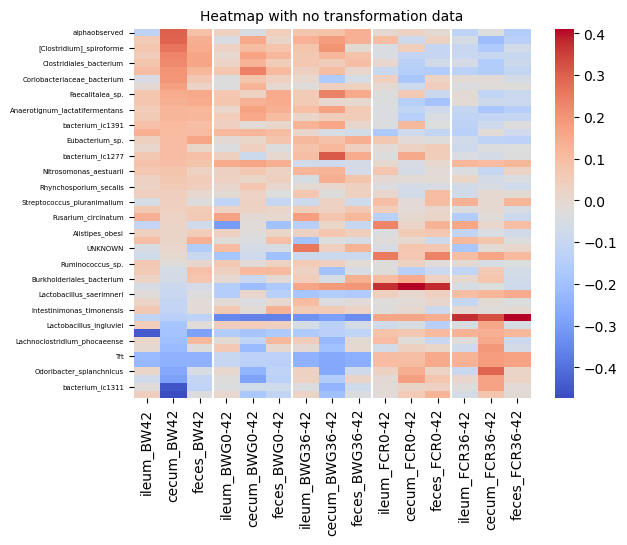

In [453]:
column_order = ['ileum_BW42', 'cecum_BW42', 'feces_BW42', 
         'ileum_BWG0-42', 'cecum_BWG0-42', 'feces_BWG0-42',
         'ileum_BWG36-42', 'cecum_BWG36-42', 'feces_BWG36-42',
         'ileum_FCR0-42', 'cecum_FCR0-42', 'feces_FCR0-42',
         'ileum_FCR36-42', 'cecum_FCR36-42', 'feces_FCR36-42']

# Crear el heatmap utilizando seaborn
fig, ax = plt.subplots()
ht1 = sns.heatmap(df_corr_f[column_order],ax = ax, cmap='coolwarm')
plt.xticks(fontsize=10)
plt.yticks(fontsize=5)
ax.axvline(3, color='w')
ax.axvline(6, color='w')
ax.axvline(9, color='w')
ax.axvline(12, color='w')
ax.set_title('Heatmap with no transformation data', fontsize=10)




plt.show()

## Heatmap CLR transformation data

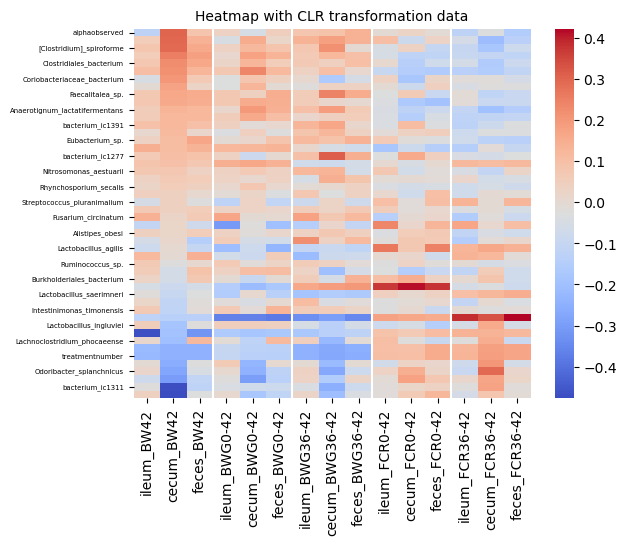

In [454]:
column_order = ['ileum_BW42', 'cecum_BW42', 'feces_BW42', 
         'ileum_BWG0-42', 'cecum_BWG0-42', 'feces_BWG0-42',
         'ileum_BWG36-42', 'cecum_BWG36-42', 'feces_BWG36-42',
         'ileum_FCR0-42', 'cecum_FCR0-42', 'feces_FCR0-42',
         'ileum_FCR36-42', 'cecum_FCR36-42', 'feces_FCR36-42']

# Crear el heatmap utilizando seaborn
fig, ax = plt.subplots()
ht2 = sns.heatmap(df_corr_clr_f[column_order],ax = ax, cmap='coolwarm')
plt.xticks(fontsize=10)
plt.yticks(fontsize=5)
ax.axvline(3, color='w')
ax.axvline(6, color='w')
ax.axvline(9, color='w')
ax.axvline(12, color='w')
ax.set_title('Heatmap with CLR transformation data', fontsize=10)



plt.show()

## Heatmap LR transformation data

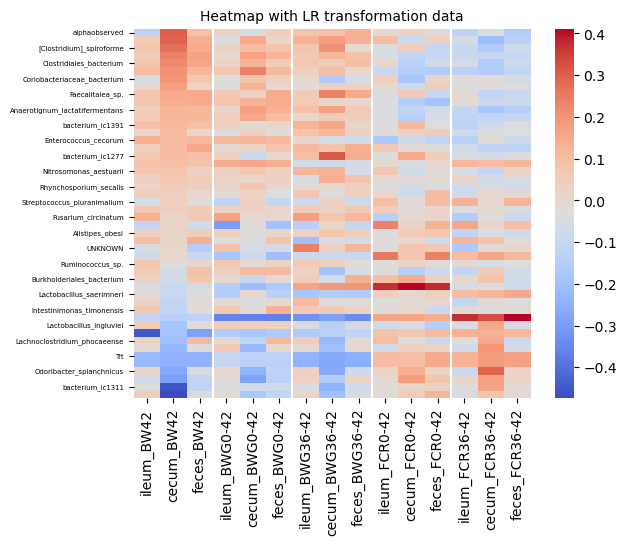

In [487]:
column_order = ['ileum_BW42', 'cecum_BW42', 'feces_BW42', 
         'ileum_BWG0-42', 'cecum_BWG0-42', 'feces_BWG0-42',
         'ileum_BWG36-42', 'cecum_BWG36-42', 'feces_BWG36-42',
         'ileum_FCR0-42', 'cecum_FCR0-42', 'feces_FCR0-42',
         'ileum_FCR36-42', 'cecum_FCR36-42', 'feces_FCR36-42']


fig, ax = plt.subplots()
ht3 = sns.heatmap(df_corr_lr_f[column_order],ax = ax, cmap='coolwarm')
plt.xticks(fontsize=10)
plt.yticks(fontsize=5)
ax.axvline(3, color='w')
ax.axvline(6, color='w')
ax.axvline(9, color='w')
ax.axvline(12, color='w')
ax.set_title('Heatmap with LR transformation data', fontsize=10)



plt.show()

# LMM test

In [346]:

# Definir una lista de las variables independientes
independientes = ['UNKNOWN',
 'bacterium_ic1277',
 'Lactobacillus_aviarius',
 'Bacteroides_plebeius',
 'Peptostreptococcus_sp.',
 'Enterococcus_cecorum',
 'Lactobacillus_coleohominis',
 'Helicobacter_pullorum',
 'Lactobacillus_agilis',
 'Prevotellaceae_bacterium',
 'Akkermansia_muciniphila',
 'Clostridiales_bacterium',
 'Odoribacter_sp.',
 'Fusobacterium_mortiferum',
 'Prevotella_sp.',
 'Anaerotignum_lactatifermentans',
 'Corynebacterium_urealyticum',
 'Lachnoclostridium_phocaeense',
 'Acinetobacter_sp.',
 'Campylobacter_lanienae',
 'Eubacterium_sp.',
 'Anaerostipes_butyraticus',
 'Prevotella_disiens',
 'Odoribacter_splanchnicus',
 'bacterium_ic1311',
 'Butyricicoccus_pullicaecorum',
 'Lactobacillus_saerimneri',
 'Clostridium_butyricum',
 'Massiliomicrobiota_timonensis',
 'Weissella_jogaejeotgali',
 '[Clostridium]_spiroforme',
 'bacterium_ic1391',
 'bacterium_ic1296',
 'Coriobacteriaceae_bacterium',
 'Streptococcus_pluranimalium',
 'Bacteroidales_bacterium',
 'Victivallis_vadensis',
 'Bacteroides_clarus',
 'Burkholderiales_bacterium',
 'Alistipes_inops',
 'Corynebacterium_aurimucosum',
 'Enterorhabdus_sp.',
 'Gordonibacter_urolithinfaciens',
 'bacterium_YE57',
 'Coprobacter_secundus',
 'poultry_manure',
 'Rikenella_microfusus',
 'Alistipes_obesi',
 'Faecalitalea_sp.',
 'Lactobacillus_ingluviei',
 'Sporosarcina_pasteurii',
 'Clostridium_sp.',
 'Intestinimonas_timonensis',
 'bacterium_QTYC46b',
 'Virgibacillus_soli',
 'Azospirillum_sp.',
 'Actinomycetales_bacterium',
 'Marinomonas_communis',
 'Peptostreptococcaceae_bacterium',
 'Bacillus_thermoamylovorans',
 'Eubacteriaceae_bacterium',
 'Corynebacterium_propinquum',
 'Sediminibacterium_sp.',
 'Sutterellaceae_bacterium',
 'Paenibacillus_motobuensis',
 'Bacillus_oleronius',
 'Tomitella_sp.',
 'Tissierella_sp.',
 'Alistipes_sp.',
 'Lachnospiraceae_bacterium',
 'Oligella_ureolytica',
 'Fusarium_circinatum',
 'Paenibacillus_fonticola',
 'Clostridium_jeddahense',
 'Bifidobacterium_subtile',
 'Candidatus_Arthromitus',
 'Trichoderma_gamsii',
 'Rhabdanaerobium_thermarum',
 'Algoriphagus_marincola',
 'Turicimonas_muris',
 'Prevotella_buccalis',
 'Lactobacillus_vaginalis',
 'Bdellovibrio_sp.','alphashannon',
 'alphaobserved']

# Definir una lista de las variables dependientes
dependientes = ['BW42',
 'FCR0-42',
 'FCR36-42',
 'BWG0-42',
 'BWG36-42']

# Iterar a través de cada variable dependiente
for dependiente in dependientes:
    print('Variable dependiente:', dependiente)
    
    # Iterar a través de cada variable independiente
    for independiente in independientes:
        print('Variable independiente:', independiente)
        
        # Seleccionar las columnas relevantes del DataFrame
        X = df_relation[independiente]
        y = df_relation[dependiente]
        
        # Ajustar el modelo de regresión lineal simple
        modelo = sm.OLS(y, sm.add_constant(X)).fit()
        
        # Imprimir los resultados del modelo
        print(modelo.summary())

Variable dependiente: BW42
Variable independiente: UNKNOWN
                            OLS Regression Results                            
Dep. Variable:                   BW42   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.626
Date:                Wed, 22 Feb 2023   Prob (F-statistic):             0.0585
Time:                        15:48:29   Log-Likelihood:                -1035.9
No. Observations:                 180   AIC:                             2076.
Df Residuals:                     178   BIC:                             2082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                   BW42   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.242
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.267
Time:                        15:48:29   Log-Likelihood:                -1037.1
No. Observations:                 180   AIC:                             2078.
Df Residuals:                     178   BIC:                             2085.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

                            OLS Regression Results                            
Dep. Variable:                   BW42   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.734
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.190
Time:                        15:48:29   Log-Likelihood:                -1036.9
No. Observations:                 180   AIC:                             2078.
Df Residuals:                     178   BIC:                             2084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

                            OLS Regression Results                            
Dep. Variable:                   BW42   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                  0.008999
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.925
Time:                        15:48:29   Log-Likelihood:                -1037.7
No. Observations:                 180   AIC:                             2079.
Df Residuals:                     178   BIC:                             2086.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2766.4747      5

                            OLS Regression Results                            
Dep. Variable:                FCR0-42   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.878
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.172
Time:                        15:48:29   Log-Likelihood:                 325.97
No. Observations:                 180   AIC:                            -647.9
Df Residuals:                     178   BIC:                            -641.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

                            OLS Regression Results                            
Dep. Variable:                FCR0-42   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     4.128
Date:                Wed, 22 Feb 2023   Prob (F-statistic):             0.0437
Time:                        15:48:30   Log-Likelihood:                 327.09
No. Observations:                 180   AIC:                            -650.2
Df Residuals:                     178   BIC:                            -643.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.6345      0.003  

                            OLS Regression Results                            
Dep. Variable:                FCR0-42   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4015
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.527
Time:                        15:48:30   Log-Likelihood:                 325.23
No. Observations:                 180   AIC:                            -646.5
Df Residuals:                     178   BIC:                            -640.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.6366      0.003  

                            OLS Regression Results                            
Dep. Variable:                FCR0-42   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1601
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.689
Time:                        15:48:30   Log-Likelihood:                 325.11
No. Observations:                 180   AIC:                            -646.2
Df Residuals:                     178   BIC:                            -639.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

                            OLS Regression Results                            
Dep. Variable:               FCR36-42   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.106
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.294
Time:                        15:48:30   Log-Likelihood:                 133.70
No. Observations:                 180   AIC:                            -263.4
Df Residuals:                     178   BIC:                            -257.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

                            OLS Regression Results                            
Dep. Variable:               FCR36-42   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.01004
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.920
Time:                        15:48:30   Log-Likelihood:                 133.15
No. Observations:                 180   AIC:                            -262.3
Df Residuals:                     178   BIC:                            -255.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

                            OLS Regression Results                            
Dep. Variable:               FCR36-42   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7050
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.402
Time:                        15:48:31   Log-Likelihood:                 133.50
No. Observations:                 180   AIC:                            -263.0
Df Residuals:                     178   BIC:                            -256.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.9234      0.009    2

                            OLS Regression Results                            
Dep. Variable:               FCR36-42   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.060
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.305
Time:                        15:48:31   Log-Likelihood:                 133.68
No. Observations:                 180   AIC:                            -263.4
Df Residuals:                     178   BIC:                            -257.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

                            OLS Regression Results                            
Dep. Variable:                BWG0-42   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8503
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.358
Time:                        15:48:31   Log-Likelihood:                -1032.7
No. Observations:                 180   AIC:                             2069.
Df Residuals:                     178   BIC:                             2076.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2719.9454 

                            OLS Regression Results                            
Dep. Variable:                BWG0-42   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.235
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.268
Time:                        15:48:31   Log-Likelihood:                -1032.5
No. Observations:                 180   AIC:                             2069.
Df Residuals:                     178   BIC:                             2075.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

                            OLS Regression Results                            
Dep. Variable:                BWG0-42   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.270
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.261
Time:                        15:48:31   Log-Likelihood:                -1032.5
No. Observations:                 180   AIC:                             2069.
Df Residuals:                     178   BIC:                             2075.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

                            OLS Regression Results                            
Dep. Variable:                BWG0-42   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.09049
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.764
Time:                        15:48:32   Log-Likelihood:                -1033.1
No. Observations:                 180   AIC:                             2070.
Df Residuals:                     178   BIC:                             2077.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

                            OLS Regression Results                            
Dep. Variable:               BWG36-42   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6941
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.406
Time:                        15:48:32   Log-Likelihood:                -950.44
No. Observations:                 180   AIC:                             1905.
Df Residuals:                     178   BIC:                             1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  632.9728 

                            OLS Regression Results                            
Dep. Variable:               BWG36-42   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8216
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.366
Time:                        15:48:32   Log-Likelihood:                -950.37
No. Observations:                 180   AIC:                             1905.
Df Residuals:                     178   BIC:                             1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

                            OLS Regression Results                            
Dep. Variable:               BWG36-42   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.565
Date:                Wed, 22 Feb 2023   Prob (F-statistic):             0.0606
Time:                        15:48:32   Log-Likelihood:                -949.00
No. Observations:                 180   AIC:                             1902.
Df Residuals:                     178   BIC:                             1908.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  631.1739 

                            OLS Regression Results                            
Dep. Variable:               BWG36-42   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.222
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.270
Time:                        15:48:33   Log-Likelihood:                -950.17
No. Observations:                 180   AIC:                             1904.
Df Residuals:                     178   BIC:                             1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             632.4570      3.567    1

In [345]:
list(df_relation.columns)

['sampleid',
 'fullsampleid',
 'kitid',
 'runid',
 'animalid',
 'samplelocation',
 'alphashannon',
 'alphaobserved',
 'kitid',
 'projectid',
 'age',
 'treatment',
 'treatmentnumber',
 'client',
 'animalid',
 'animaltype',
 'animalnumber',
 'house',
 'pen',
 'Block',
 'Trt',
 'BW42',
 'FCR0-42',
 'FCR36-42',
 'BWG0-42',
 'BWG36-42',
 'UNKNOWN',
 'bacterium_ic1277',
 'Lactobacillus_aviarius',
 'Bacteroides_plebeius',
 'Peptostreptococcus_sp.',
 'Enterococcus_cecorum',
 'Lactobacillus_coleohominis',
 'Helicobacter_pullorum',
 'Lactobacillus_agilis',
 'Prevotellaceae_bacterium',
 'Akkermansia_muciniphila',
 'Clostridiales_bacterium',
 'Odoribacter_sp.',
 'Fusobacterium_mortiferum',
 'Prevotella_sp.',
 'Anaerotignum_lactatifermentans',
 'Corynebacterium_urealyticum',
 'Lachnoclostridium_phocaeense',
 'Acinetobacter_sp.',
 'Campylobacter_lanienae',
 'Eubacterium_sp.',
 'Anaerostipes_butyraticus',
 'Prevotella_disiens',
 'Odoribacter_splanchnicus',
 'bacterium_ic1311',
 'Butyricicoccus_pullic